# Projet classification de données hyperspectrales

Les images hyperspectrales sont un type de données que nous avez déjà étudiées et traitées dans un des tout premier TP. Une image hyperspectrale correspond à une image dont le contenu spectral (aka. le nombre de couleurs) est enrichi par rapport aux images RGB acquises par exemple avec vos téléphonnes portable. 


L'objectif de ce mini-projet est une compétition (entre vous) pour la classification des pixels d'une image hyperspectrale.


Vous allez avoir à disposition une image hyperspectrale (survol de l'Université de Houston). Votre objectif est de déterminer automatiquement la nature des pixels qui composent l'image.

## Lecture des données

Vous avez à votre disposition le fichier `houston.npz` que nous allons ouvrir et analyser.

Commençon par quelques imports utiles.

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib import cm


In [2]:
houston = np.load('houston.npz')

La variable `houston` comprend un ensemble de deux numpy arrays :

In [3]:
hyp = houston["hyp_img"] # image hyperspectrale
label = houston["label_img"] # données d'apprentissage

dont les dimensions sont les suivantes :

In [4]:
print(hyp.shape)
print(label.shape)

(1202, 4768, 48)
(1202, 4768)


## Visualisation des données

La variable `hyp` correspond à l'image hyperspectrale. Nous sélectionnons trois bandes pour la visualisation.

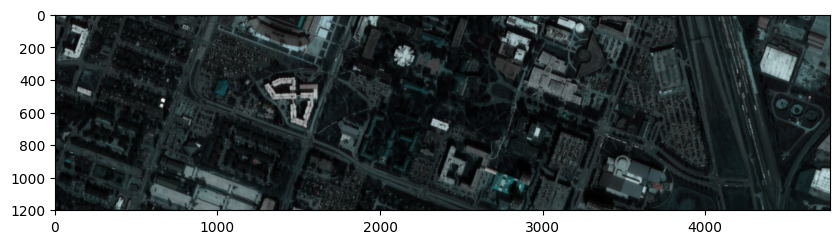

In [120]:
# Bands selected
# nbands=[35,20,5]
nbands=[10,21,22]

plt.figure(figsize=(10,15))
plt.imshow(hyp[:,:,nbands])
plt.show()

L'image `label` donne pour chaque pixel de l'image une information sur la classe du pixel avec la nomenclature suivante:
0 – inconnu (à ne pas utiliser !)
1 – Herbes saines
2 – Herbes en état de stress hydrique
3 – Conifères
4 - Feuillus
5 – Bâtiments résidentiels
6 – Bâtiments non-résidentiels
7 – Routes
8 – Trottoirs
9 – Carrefour
10 – Grands axes routiers
11 – Stationnements asphaltés
12 – Voitures

La fonction suivante permet de visualiser cette image. Les pixels blancs indiquent les endroits où les étiquettes ne sont pas disponibles, qui correspondent à la **classe 0**.

In [96]:
def viz_label_img(label_img):
    N = len(np.bincount(label_img.flatten())) # nombre d'étiquettes uniques
    colours = cm.get_cmap("tab10",N)
    cmap = colours(np.linspace(0, 1, N))  # obtenir une image RGB
    cmap[0,-1] = 0  # transparent pour les pixels à étiquetter
    print(cmap.shape)
    display_img = cmap[label_img.flatten()]
    display_img = display_img.reshape((label_img.shape[0], label_img.shape[1], -1))
    return display_img

In [7]:
np.where(label != 0)
print(label[np.where(label != 0)])

[12 12 12 ...  6  6  6]


In [8]:
np.bincount(label.flatten())

array([4973752,   11820,   28180,   35779,   13367,   34125,  413636,
         55268,   86094,    3085,   50607,   15247,   10176])

(13, 4)


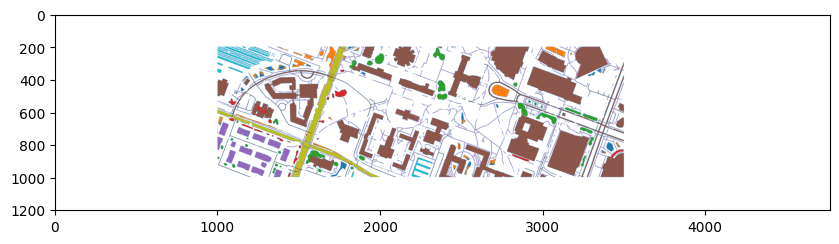

In [9]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(label))
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
(1202, 4768)
(920, 1500)
(13, 4)


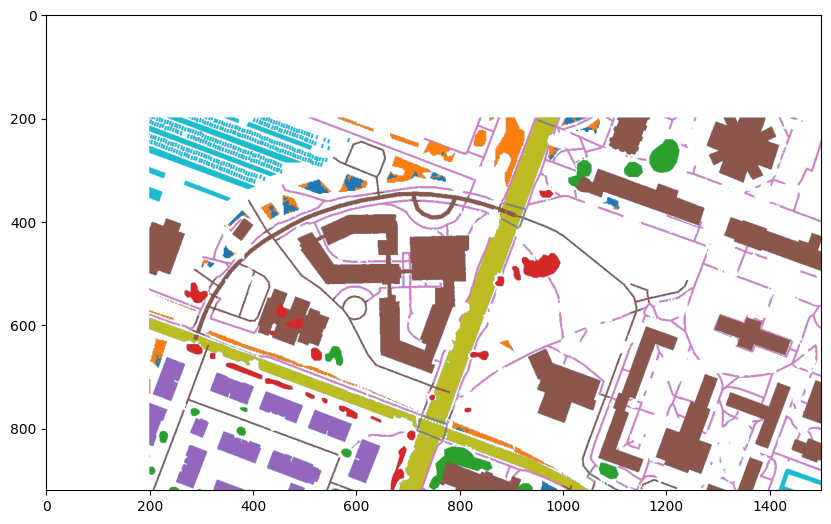

In [98]:
window = label[:920, 800:2300]
print(np.unique(label.flatten()))
print(np.unique(window.flatten()))
print(label.shape)
print(window.shape)
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(window))
plt.show()

In [56]:
print(label[np.where(label != 0)])


[12 12 12 ...  6  6  6]
[[ 35  27  40 ...  71  71  74]
 [ 35  27  40 ...  71  71  74]
 [ 37  28  31 ...  51  56  53]
 ...
 [ 49  40  53 ... 107 112 123]
 [ 50  42  54 ... 108 117 117]
 [ 50  42  54 ... 108 117 117]]
[12 12 12 ...  6  6  6]


## Objectif du challenge

Sur la visualisation précédente, vous voyez beaucoup de pixels blancs pour laquelle la classe n'est pas connue. 

Votre **objectif** est d'obtenir la classe de tous les pixels de l'image `img` avec une méthode aussi **précise** que possible. 

L'évaluation prendra en compte les éléments suivants:
1. La qualité du protocole expérimental mis en place, et sa **justification**
2. Les éventuels pré-traitement utilisés
3. Les méthodes de classification utilisées (toutes les méthodes implémentées par scikit-learn peuvent être utilisées, même celles que nous n'avons pas vu en cours)
4. La recherche d'une solution aussi précise que possible et le choix des métriques utilisées

## Rendu

1. Code

Vous crééerez un projet GIT sous https://forgens.univ-ubs.fr/gitlab/ auquel j'aurais accès. 
Ce projet doit contenir tous vos développements en Python sous forme de notebooks ou scripts.

2. Meilleures prédictions

Sous Moodle, un.e membre du groupe remettra un fichier `.npy` dont la structure est équivalente à celle de `label` mais où chaque pixel a une valeur de 1 à 12 (pas de 0) représentant une des classes à prédire.

In [116]:
train_X = hyp[label != 0]
train_y = label[label != 0]

print(hyp.shape)
challenge_X = hyp.reshape((-1,48))

(1202, 4768, 48)
(5731136, 48)


In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')


In [106]:
from sklearn.ensemble import RandomForestClassifier
# TODO: add min samples leaf
clf = RandomForestClassifier(max_depth=25, random_state=0, n_jobs=8, n_estimators=25)
clf.fit(train_X, train_y)


RandomForestClassifier(max_depth=25, n_estimators=25, n_jobs=8, random_state=0)

In [117]:
predict = clf.predict(challenge_X)

In [118]:
res = predict.reshape(label.shape)


(13, 4)


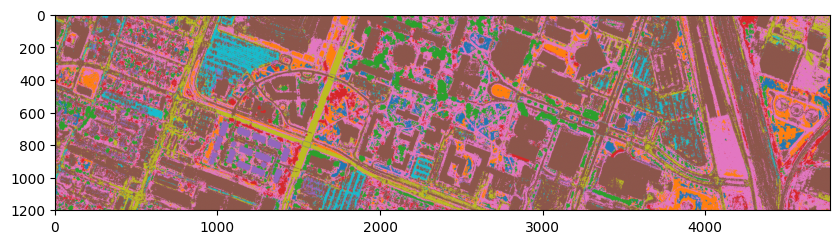

In [119]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(res))
plt.show()